#Importing libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight
import pywt

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Covid_mrinal/CovidXRay.rar

Streaming output truncated to the last 5000 lines.
Extracting  Chest X-Ray image dataset/Normal/Normal-6710.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6711.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6712.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6713.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6714.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6715.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6716.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6717.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6718.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6719.png              75%  OK 
Extracting  Chest X-Ray image

#Loading main dataset

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/Chest X-Ray image dataset"):
  class_path = f"/content/Chest X-Ray image dataset/{i}"
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (224, 224)))

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
# del train_images,train_labels

In [ ]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

#Upsampling dataset

In [ ]:
covid = []
lung_opacity = []
normal = []
viral_pneumonia = []
for i,j in list(zip(train_images, train_labels)):
  if j == "COVID":
    covid.append(i)
  elif j == "Lung opacity":
    lung_opacity.append(i)
  elif j == "Normal":
    normal.append(i)
  elif j == "Viral Pneumonia":
    viral_pneumonia.append(i)

In [ ]:
covid = np.asarray(covid)
lung_opacity = np.asarray(lung_opacity)
normal = np.asarray(normal)
viral_pneumonia = np.asarray(viral_pneumonia)

In [ ]:
print(f"COVID : {covid.shape}\tLung Opacity : {lung_opacity.shape}\tNormal : {normal.shape}\tViral Pneumonia : {viral_pneumonia.shape}")

COVID : (2915, 224, 224, 3)	Lung Opacity : (4837, 224, 224, 3)	Normal : (8104, 224, 224, 3)	Viral Pneumonia : (1076, 224, 224, 3)


In [ ]:
covid_selected = covid
lung_opacity_selected = lung_opacity[np.random.choice(lung_opacity.shape[0], size=lung_opacity.shape[0] - 1000)]
normal_selected = normal[np.random.choice(normal.shape[0], size=normal.shape[0] - 4000)]
viral_pneumonia_selected = viral_pneumonia

In [ ]:
print(f"COVID : {covid_selected.shape}\tLung Opacity : {lung_opacity_selected.shape}\tNormal : {normal_selected.shape}\tViral Pneumonia : {viral_pneumonia_selected.shape}")

COVID : (2915, 224, 224, 3)	Lung Opacity : (3837, 224, 224, 3)	Normal : (4104, 224, 224, 3)	Viral Pneumonia : (1076, 224, 224, 3)


In [ ]:
del covid, lung_opacity, normal, viral_pneumonia

In [ ]:
def clahe(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    bgr = bgr.astype(np.float32)/255
    return bgr

In [ ]:
def claheInt(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # bgr = bgr.astype('float32')/255
    return bgr

In [ ]:
def svdstdwithoutdecompostionC(imageA):
  image = imageA
  image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  target_im = cv2.imread('/content/Chest X-Ray image dataset/COVID/COVID-32.png')
  target_im = cv2.cvtColor(target_im, cv2.COLOR_RGB2GRAY)
  st = np.std(image)
  st1 = np.std(target_im)
  mean  =np.mean(image)
  mean1 = np.mean(target_im)
  c = st/mean
  c1 = st1/mean1
  if c1 > c:
    ratio = 1.05 + ((c1-c)/(c1+c))
  else:
  #  print("Original image contrast is better than the target image")
   ratio = 1.05
  u1, s1, v1 = np.linalg.svd(target_im)
  u2, s2, v2 = np.linalg.svd(image)
  s2_new= ratio * s2
  cmpimg = np.matrix(u2[:,:],dtype=np.float32) * np.diag(s2_new[:]) * np.matrix(v2[:,:],dtype=np.float32)
  final_img = cmpimg
  final_img = np.array(final_img, dtype=np.float32)
  # cv2_imshow(final_img)
  final_img  = cv2.cvtColor(final_img, cv2.COLOR_GRAY2RGB) / 255
  final_img = NormalizeData(final_img)
  # final_img = final_img.astype(dtype=np.float16)/255
  return final_img

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

##Upsampling COVID

In [ ]:
# test_images = test_images.astype(np.float32) / 255

In [ ]:
covid_clahe_point_5 = [clahe(x, 0.5, 8) for x in covid_selected]
covid_preprocessed_custom = [svdstdwithoutdecompostionC(x) for x in covid_selected]

##Upsampling Viral Pneumonia

In [ ]:
viral_pneumonia_clahe_point_5 = [clahe(x, 0.5, 8) for x in viral_pneumonia_selected]
viral_pneumonia_clahe_1 = [clahe(x, 1, 8) for x in viral_pneumonia_selected]
viral_pneumonia_preprocessed_custom = [svdstdwithoutdecompostionC(x) for x in viral_pneumonia_selected]

In [ ]:
viral_pneumonia_preprocessed_custom_with_clahe_point_5 = [svdstdwithoutdecompostionC(claheInt(x, 0.5, 8)) for x in viral_pneumonia_selected]

In [ ]:
covid_final = []
for i in covid_clahe_point_5:
  covid_final.append(i)
for i in covid_preprocessed_custom:
  covid_final.append(i)
for i in covid_selected:
  covid_final.append(i.astype(np.float16)/255)

viral_pneumonia_final = []
for i in viral_pneumonia_clahe_point_5:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_clahe_1:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_preprocessed_custom:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_preprocessed_custom_with_clahe_point_5:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_selected:
  viral_pneumonia_final.append(i.astype(np.float16)/255)

In [ ]:
del covid_selected, viral_pneumonia_selected, covid_clahe_point_5, covid_preprocessed_custom, viral_pneumonia_clahe_point_5, viral_pneumonia_clahe_1, viral_pneumonia_preprocessed_custom, viral_pneumonia_preprocessed_custom_with_clahe_point_5

In [ ]:
lung_opacity_inter = [clahe(x, 0.5, 8) for x in lung_opacity_selected]
normal_inter = [clahe(x, 0.5, 8) for x in normal_selected]

In [ ]:
lung_opacity_final = []
for i in lung_opacity_selected:
  lung_opacity_final.append(i.astype(np.float16)/255)
for i in lung_opacity_inter:
  lung_opacity_final.append(i)

In [ ]:
del lung_opacity_selected, lung_opacity_inter

In [ ]:
X_train = []
Y_train = []
for i in covid_final:
  X_train.append(i)
  Y_train.append("COVID")
for i in lung_opacity_final:
  X_train.append(i)
  Y_train.append("Lung opacity")
for i in viral_pneumonia_final:
  X_train.append(i)
  Y_train.append("Viral Pneumonia")

In [ ]:
del covid_final, lung_opacity_final, viral_pneumonia_final

In [ ]:
normal_final = []
for i in normal_selected:
  normal_final.append(i.astype(np.float16)/255)
for i in normal_inter:
  normal_final.append(i)

In [ ]:
for i in normal_final:
  X_train.append(i)
  Y_train.append("Normal")

In [ ]:
del normal_selected, normal_inter, normal_final

In [ ]:
len(X_train)

30007

In [ ]:
len(Y_train)

30007

In [ ]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)

In [ ]:
import pickle 
pickle.dump(lb, open('binarizer.pkl', 'wb'))

In [ ]:
del lb

In [ ]:
X_train = np.array(X_train, dtype=np.float16)

In [ ]:
X_train.shape

(18011, 224, 224, 3)

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:

def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

#Image Generator

In [ ]:
num_images = [8745, 7674, 8214, 5365]

In [ ]:
sum(num_images)

29998

In [ ]:
num_classes = len(num_images)-1

In [ ]:
beta_values = [(1 - (x / sum(num_images))) / num_classes for x in num_images]

In [ ]:
beta = dict(zip([0, 1, 2, 3], beta_values))

In [ ]:
image_generator = ImageDataGenerator(validation_split = 0.2)

In [ ]:
train_dataset = image_generator.flow_from_directory(directory="/content/drive/MyDrive/Covid_mrinal/Preprocessed", target_size=(224, 224), color_mode="rgb", class_mode="categorical", shuffle=True, subset="training")

Found 24000 images belonging to 4 classes.


In [ ]:
validation_dataset = image_generator.flow_from_directory(directory="/content/drive/MyDrive/Covid_mrinal/Preprocessed", target_size=(224, 224), color_mode="rgb", class_mode="categorical", shuffle=True, subset="validation")

Found 5998 images belonging to 4 classes.


In [ ]:
beta

{0: 0.23616018845700823,
 1: 0.248060981843234,
 2: 0.24206058181656553,
 3: 0.2737182478831922}

In [ ]:
train_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

#VGG19 without class weights

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model =VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
# base_model.summary()
final_model = keras.models.Sequential([base_model, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
history = final_model.fit(x=train_dataset, validation_data=validation_dataset, epochs=20, batch_size=32, callbacks=[early_stoping])

Epoch 1/20
750/750 [==============================] - 8357s 11s/step - loss: 2.6532 - accuracy: 0.6803 - precision: 0.8943 - recall: 0.8942 - auc: 0.9417 - specificity: 0.7713 - sensitivity: 0.5760 - mcc: 0.7859 - val_loss: 3.0539 - val_accuracy: 0.8024 - val_precision: 0.9076 - val_recall: 0.9073 - val_auc: 0.9458 - val_specificity: 0.8378 - val_sensitivity: 0.5984 - val_mcc: 0.8359
Epoch 2/20
750/750 [==============================] - 338s 450ms/step - loss: 1.1580 - accuracy: 0.8629 - precision: 0.9574 - recall: 0.9574 - auc: 0.9761 - specificity: 0.9327 - sensitivity: 0.6980 - mcc: 0.9089 - val_loss: 1.4030 - val_accuracy: 0.8815 - val_precision: 0.9543 - val_recall: 0.9543 - val_auc: 0.9735 - val_specificity: 0.8989 - val_sensitivity: 0.7128 - val_mcc: 0.9215
Epoch 3/20
750/750 [==============================] - 336s 448ms/step - loss: 0.8873 - accuracy: 0.9093 - precision: 0.9689 - recall: 0.9688 - auc: 0.9824 - specificity: 0.9373 - sensitivity: 0.6900 - mcc: 0.9292 - val_loss: 

In [ ]:
df = data(history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.680323,0.802392,2.653198,3.053882,0.894250,0.907302,0.894325,0.907605,0.941710,0.945840,0.771333,0.837766,0.576000,0.598404,0.785889,0.835888
1,0.862917,0.881502,1.158044,1.402986,0.957417,0.954318,0.957417,0.954318,0.976141,0.973516,0.932667,0.898936,0.698000,0.712766,0.908916,0.921542
2,0.909271,0.908219,0.887311,1.376100,0.968833,0.957819,0.968874,0.957819,0.982361,0.975170,0.937333,0.901596,0.690000,0.635638,0.929196,0.909131
3,0.931646,0.922766,0.606325,1.418405,0.978250,0.959153,0.978250,0.959153,0.987368,0.976330,0.970667,0.920213,0.709333,0.731383,0.958222,0.922872
4,0.950771,0.948191,0.428102,0.358754,0.984833,0.987496,0.984833,0.987496,0.991365,0.992760,0.976000,0.994681,0.712667,0.723404,0.972418,0.968528
5,0.957521,0.961237,0.432522,0.440851,0.985250,0.987663,0.985250,0.987663,0.991624,0.992754,0.968667,0.976064,0.713333,0.750000,0.964178,0.967094
6,0.967719,0.965405,0.414803,0.287086,0.988750,0.989997,0.988750,0.989997,0.993708,0.994203,0.974667,0.994681,0.722667,0.686170,0.975333,0.987589
7,0.968500,0.962154,0.454006,0.690248,0.985958,0.981327,0.985958,0.981327,0.991745,0.988856,0.979333,0.968085,0.734667,0.664894,0.972752,0.958777
8,0.976135,0.975700,0.358325,0.367429,0.989333,0.989496,0.989333,0.989496,0.993553,0.993438,0.977333,0.984042,0.691333,0.672872,0.971889,0.972518
9,0.980563,0.971782,0.324747,0.593968,0.991458,0.984161,0.991458,0.984161,0.995167,0.991335,0.981333,0.976064,0.711333,0.696808,0.979889,0.967199


In [ ]:
df.to_csv("vgg_19_with_30k_with_bwcce.csv")

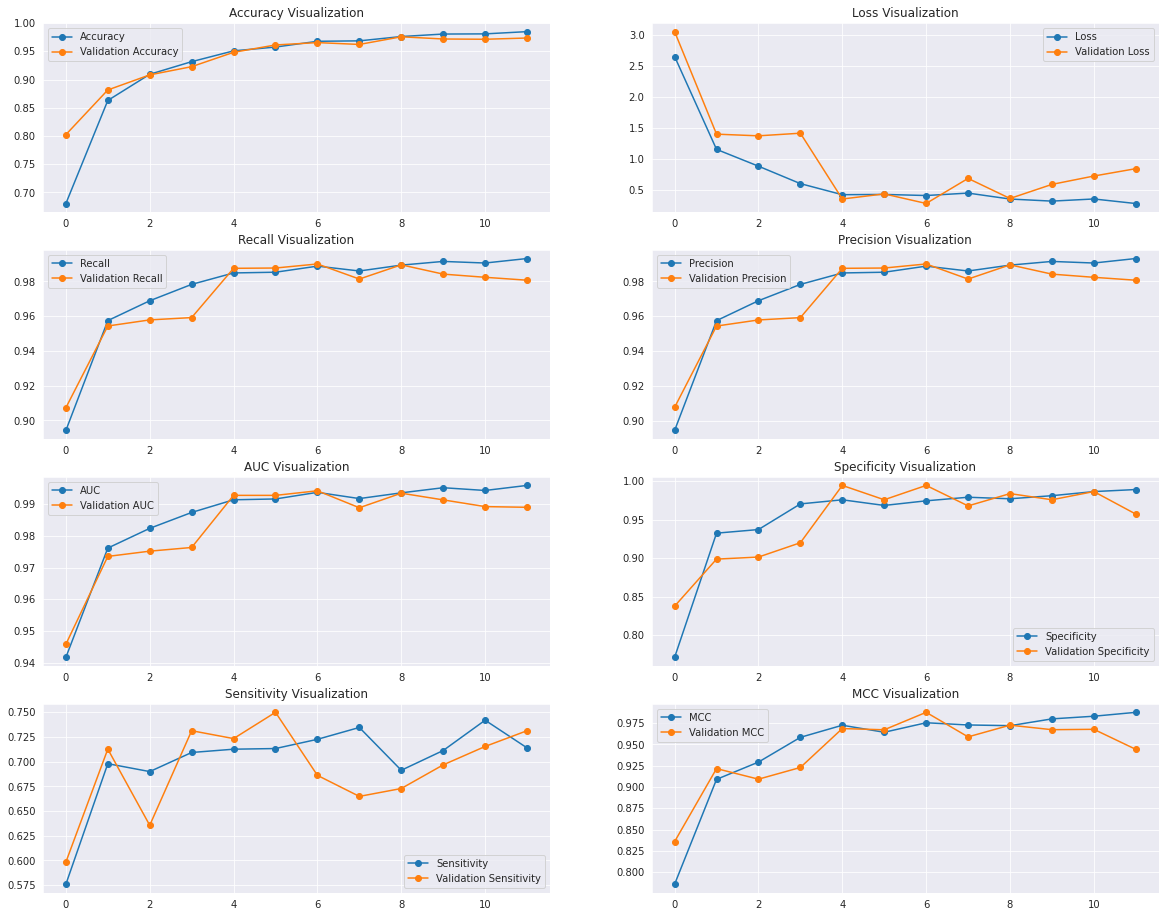

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k_with_class_weights_with_bwcce.h5")

In [ ]:
predictions = final_model.predict(test_images)
predictions_index = np.argmax(predictions, axis = -1)
test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)
print(classification_report(predictions_index, test_labels_index))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95       772
           1       0.90      0.90      0.90      1173
           2       0.91      0.95      0.93      1989
           3       1.00      0.91      0.95       299

    accuracy                           0.93      4233
   macro avg       0.95      0.92      0.93      4233
weighted avg       0.93      0.93      0.93      4233



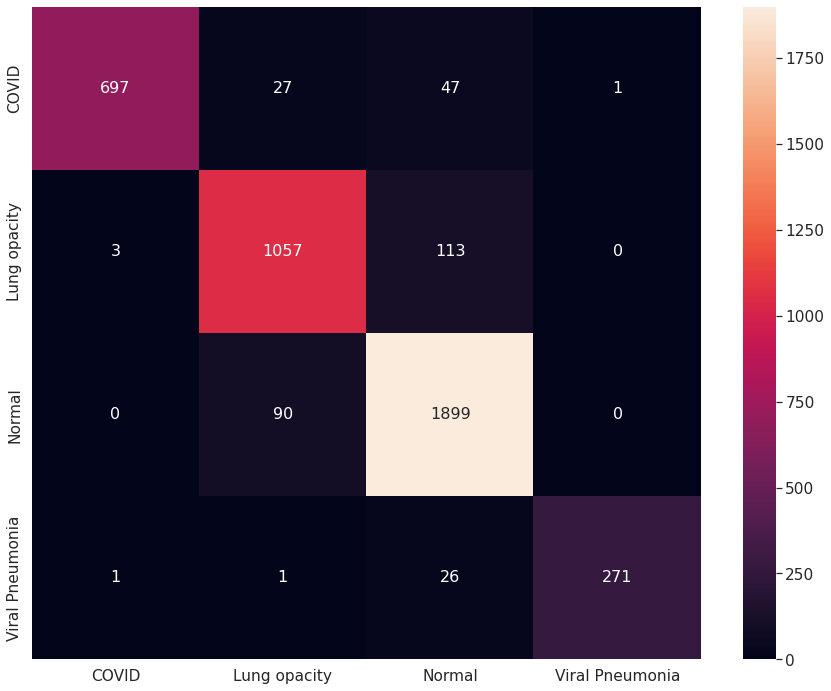

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, test_labels_index)
df_cm = pd.DataFrame(cm, index = [i for i in train_dataset.class_indices],
                  columns = [i for i in train_dataset.class_indices])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

#VGG19 with weighted cross entropy

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_dataset.classes), 
                train_dataset.classes)

In [ ]:
class_weights

array([0.85763293, 0.9771987 , 0.91296409, 1.39794967])

In [ ]:
weights = dict(zip([0, 1, 2, 3], class_weights))

In [ ]:
weights

{0: 0.8576329331046312,
 1: 0.9771986970684039,
 2: 0.9129640900791236,
 3: 1.3979496738117427}

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model =VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
# base_model.summary()
final_model = keras.models.Sequential([base_model, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
history = final_model.fit(x=train_dataset, validation_data=validation_dataset, epochs=20, batch_size=32, callbacks=[early_stoping],  class_weight=weights)

Epoch 1/20
750/750 [==============================] - 7339s 10s/step - loss: 2.5287 - accuracy: 0.6639 - precision: 0.8960 - recall: 0.8959 - auc: 0.9422 - specificity: 0.7927 - sensitivity: 0.5873 - mcc: 0.7797 - val_loss: 1.3334 - val_accuracy: 0.7826 - val_precision: 0.9471 - val_recall: 0.9471 - val_auc: 0.9714 - val_specificity: 0.9229 - val_sensitivity: 0.6543 - val_mcc: 0.8843
Epoch 2/20
750/750 [==============================] - 316s 422ms/step - loss: 1.1200 - accuracy: 0.8486 - precision: 0.9557 - recall: 0.9557 - auc: 0.9760 - specificity: 0.9193 - sensitivity: 0.6833 - mcc: 0.9040 - val_loss: 1.1204 - val_accuracy: 0.8600 - val_precision: 0.9555 - val_recall: 0.9555 - val_auc: 0.9742 - val_specificity: 0.9521 - val_sensitivity: 0.6995 - val_mcc: 0.9130
Epoch 3/20
750/750 [==============================] - 316s 421ms/step - loss: 0.6709 - accuracy: 0.9013 - precision: 0.9720 - recall: 0.9720 - auc: 0.9847 - specificity: 0.9480 - sensitivity: 0.7073 - mcc: 0.9373 - val_loss: 

In [ ]:
df = data(history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.663938,0.782636,2.528700,1.333371,0.895917,0.947149,0.895954,0.947149,0.942214,0.971372,0.792667,0.922872,0.587333,0.654255,0.779685,0.884309
1,0.848573,0.859953,1.120045,1.120435,0.955667,0.955485,0.955667,0.955485,0.976021,0.974184,0.919333,0.952128,0.683333,0.699468,0.903974,0.913016
2,0.901344,0.846657,0.670887,3.035813,0.971958,0.909136,0.971958,0.909136,0.984695,0.946704,0.948000,0.835106,0.707333,0.598404,0.937333,0.817819
3,0.927792,0.935103,0.522539,0.701373,0.979125,0.980160,0.979125,0.980160,0.988521,0.988299,0.955333,0.973404,0.709333,0.731383,0.953333,0.961436
4,0.946354,0.943606,0.560924,0.436285,0.980208,0.981160,0.980208,0.981160,0.989115,0.989865,0.963333,0.962766,0.746667,0.792553,0.960444,0.963209
5,0.957521,0.952859,0.382975,0.837553,0.985375,0.977826,0.985375,0.977826,0.991698,0.986620,0.981333,0.960106,0.730667,0.707447,0.975000,0.950355
6,0.964125,0.948274,0.431789,1.333859,0.985000,0.966822,0.985000,0.966822,0.991455,0.980143,0.980667,0.954787,0.735333,0.742021,0.969000,0.935622
7,0.974427,0.968156,0.273034,0.537949,0.991333,0.985328,0.991333,0.985328,0.994978,0.991423,0.976667,0.973404,0.722000,0.691489,0.978000,0.968528
8,0.973083,0.975700,0.401240,0.468571,0.988000,0.988496,0.988000,0.988496,0.993345,0.992822,0.980667,0.968085,0.713333,0.715425,0.975222,0.957890
9,0.978615,0.975283,0.328664,0.490534,0.989958,0.989163,0.989958,0.989163,0.994101,0.993709,0.987333,0.986702,0.736667,0.686170,0.977622,0.975177


In [ ]:
df.to_csv("vgg_19_with_30k_with_wcce.csv")

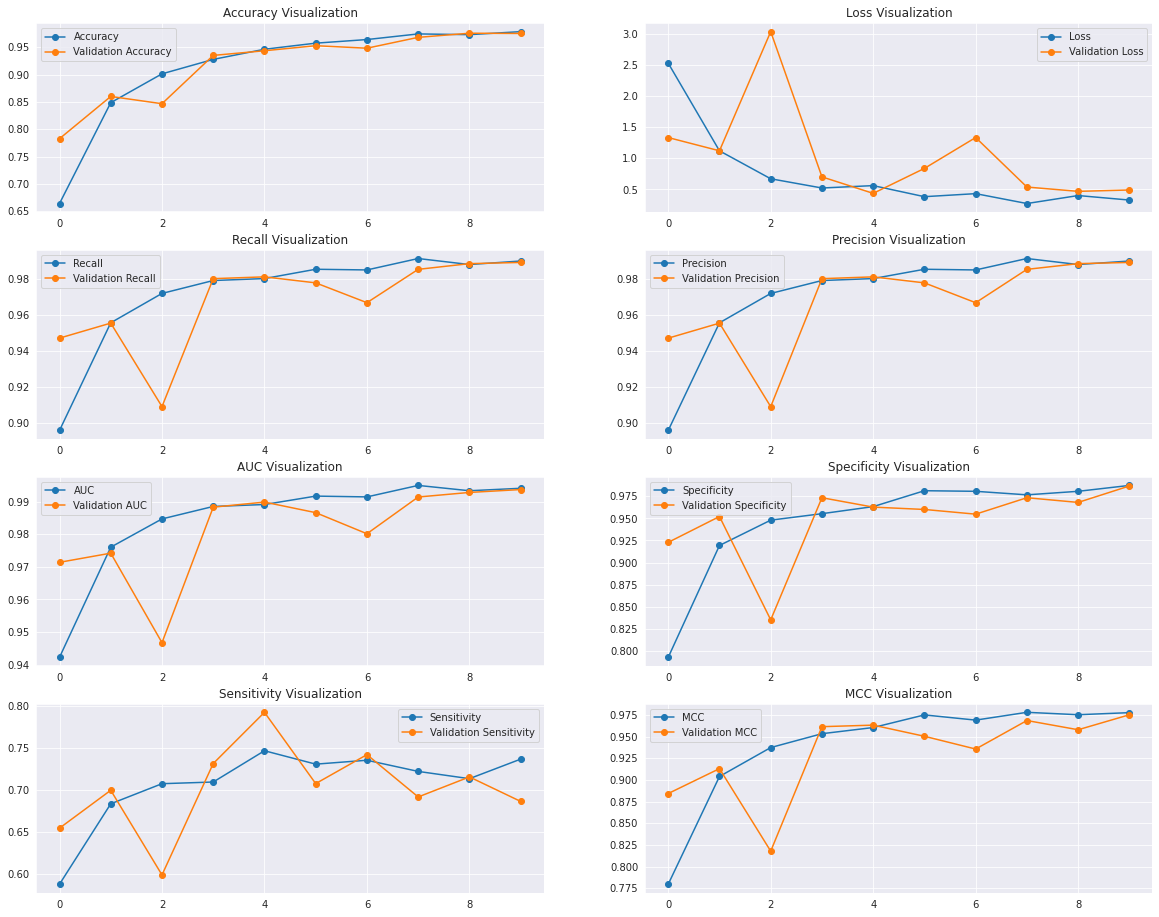

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k_with_class_weights_with_bwcce.h5")

In [ ]:
predictions = final_model.predict(test_images)
predictions_index = np.argmax(predictions, axis = -1)
test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)
print(classification_report(predictions_index, test_labels_index))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       746
           1       0.93      0.88      0.91      1239
           2       0.92      0.96      0.94      1969
           3       1.00      0.97      0.98       279

    accuracy                           0.94      4233
   macro avg       0.95      0.94      0.95      4233
weighted avg       0.94      0.94      0.94      4233



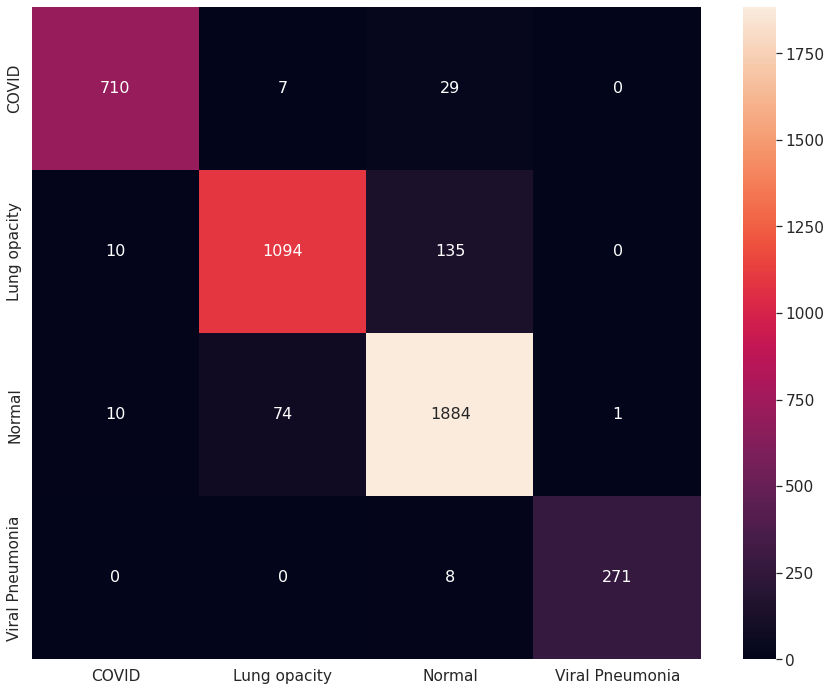

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, test_labels_index)
df_cm = pd.DataFrame(cm, index = [i for i in train_dataset.class_indices],
                  columns = [i for i in train_dataset.class_indices])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

#VGG19 with class weights using BWCCE

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model =VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
# base_model.summary()
final_model = keras.models.Sequential([base_model, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
history = final_model.fit(x=train_dataset, validation_data=validation_dataset, epochs=20, batch_size=32, callbacks=[early_stoping],  class_weight=beta)

Epoch 1/20
750/750 [==============================] - 18433s 25s/step - loss: 0.6911 - accuracy: 0.6875 - precision: 0.8946 - recall: 0.8945 - auc: 0.9406 - specificity: 0.8113 - sensitivity: 0.5787 - mcc: 0.7766 - val_loss: 1.5242 - val_accuracy: 0.7803 - val_precision: 0.9341 - val_recall: 0.9341 - val_auc: 0.9634 - val_specificity: 0.8883 - val_sensitivity: 0.5824 - val_mcc: 0.8599
Epoch 2/20
750/750 [==============================] - 333s 444ms/step - loss: 0.2587 - accuracy: 0.8587 - precision: 0.9602 - recall: 0.9602 - auc: 0.9782 - specificity: 0.9273 - sensitivity: 0.6867 - mcc: 0.9134 - val_loss: 1.0499 - val_accuracy: 0.8926 - val_precision: 0.9653 - val_recall: 0.9653 - val_auc: 0.9807 - val_specificity: 0.9654 - val_sensitivity: 0.6835 - val_mcc: 0.9260
Epoch 3/20
750/750 [==============================] - 330s 440ms/step - loss: 0.1842 - accuracy: 0.9050 - precision: 0.9729 - recall: 0.9729 - auc: 0.9848 - specificity: 0.9520 - sensitivity: 0.7147 - mcc: 0.9372 - val_loss:

In [ ]:
df = data(history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.687479,0.780302,0.691065,1.524194,0.894500,0.934145,0.894575,0.934145,0.940599,0.963431,0.811333,0.888298,0.578667,0.582447,0.776640,0.859929
1,0.858750,0.892589,0.258665,1.049915,0.960208,0.965322,0.960208,0.965322,0.978151,0.980749,0.927333,0.965425,0.686667,0.683511,0.913445,0.925975
2,0.905021,0.907136,0.184150,0.790136,0.972917,0.973158,0.972917,0.973158,0.984837,0.984138,0.952000,0.944149,0.714667,0.683511,0.937222,0.942376
3,0.930656,0.936729,0.144959,0.493339,0.978542,0.981327,0.978542,0.981327,0.987924,0.990165,0.942667,0.960106,0.713333,0.686170,0.947111,0.958777
4,0.947354,0.943231,0.127219,0.578039,0.981583,0.979493,0.981583,0.979493,0.989623,0.987321,0.972667,0.960106,0.724000,0.662234,0.965640,0.951241
5,0.960437,0.951942,0.116555,0.800877,0.985292,0.976159,0.985333,0.976159,0.991809,0.985976,0.972667,0.968085,0.728667,0.694149,0.969059,0.956117
6,0.963479,0.968573,0.149993,0.412827,0.983125,0.987663,0.983125,0.987663,0.990069,0.993007,0.966667,0.981383,0.706667,0.718085,0.967764,0.971631
7,0.976271,0.970198,0.055017,0.380872,0.992417,0.988830,0.992417,0.988994,0.995922,0.993761,0.982000,0.978723,0.712000,0.707447,0.984222,0.974291
8,0.976177,0.972324,0.076368,0.128035,0.990542,0.993665,0.990542,0.993665,0.994444,0.996439,0.982667,0.986702,0.718000,0.723404,0.980000,0.984486
9,0.977656,0.973408,0.103220,0.439234,0.988792,0.986495,0.988792,0.986495,0.993517,0.992560,0.984000,0.973404,0.753333,0.723404,0.975444,0.964096


In [ ]:
df.to_csv("vgg_19_with_30k_with_bwcce.csv")

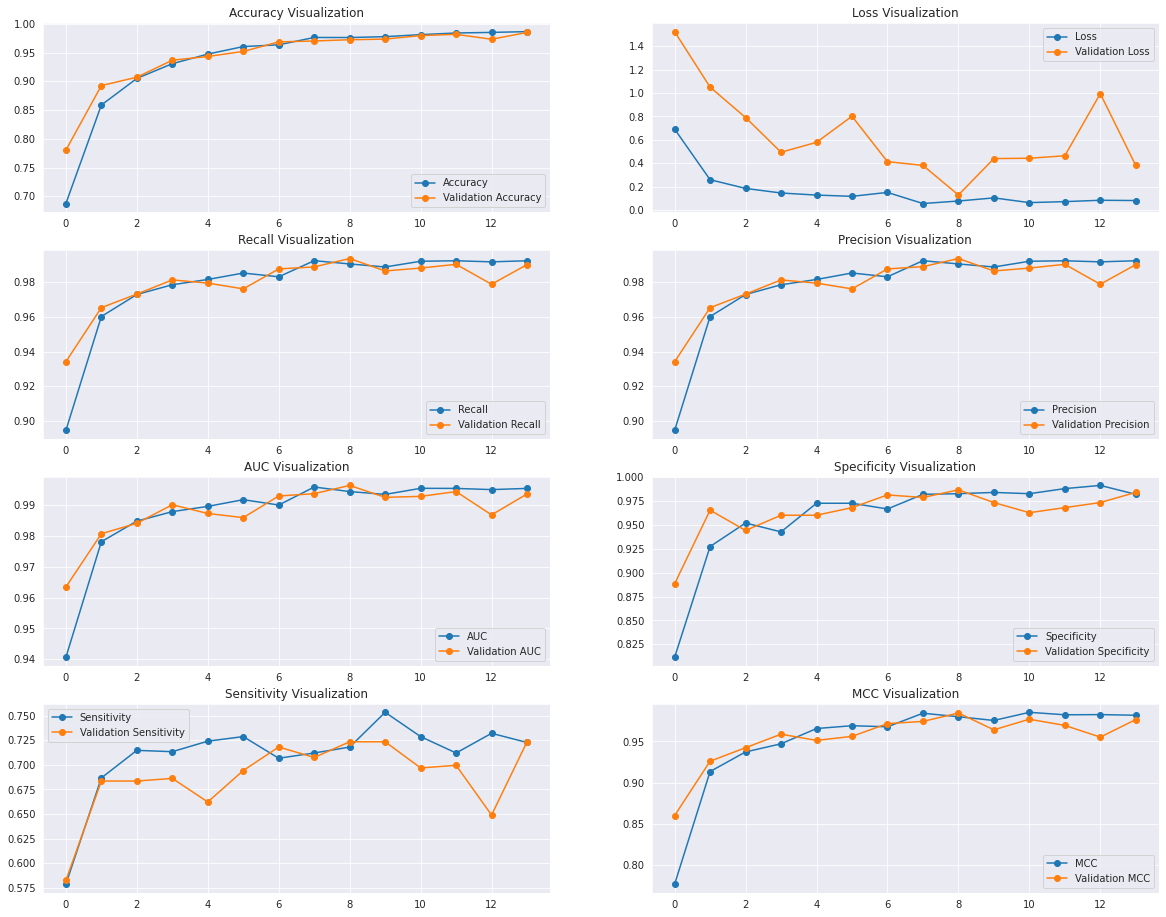

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k_with_class_weights_with_bwcce.h5")

In [ ]:
predictions = final_model.predict(test_images)
predictions_index = np.argmax(predictions, axis = -1)
test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)
print(classification_report(predictions_index, test_labels_index))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       740
           1       0.93      0.90      0.91      1214
           2       0.93      0.96      0.95      2041
           3       0.99      0.97      0.98       238

    accuracy                           0.94      4233
   macro avg       0.96      0.95      0.95      4233
weighted avg       0.94      0.94      0.94      4233



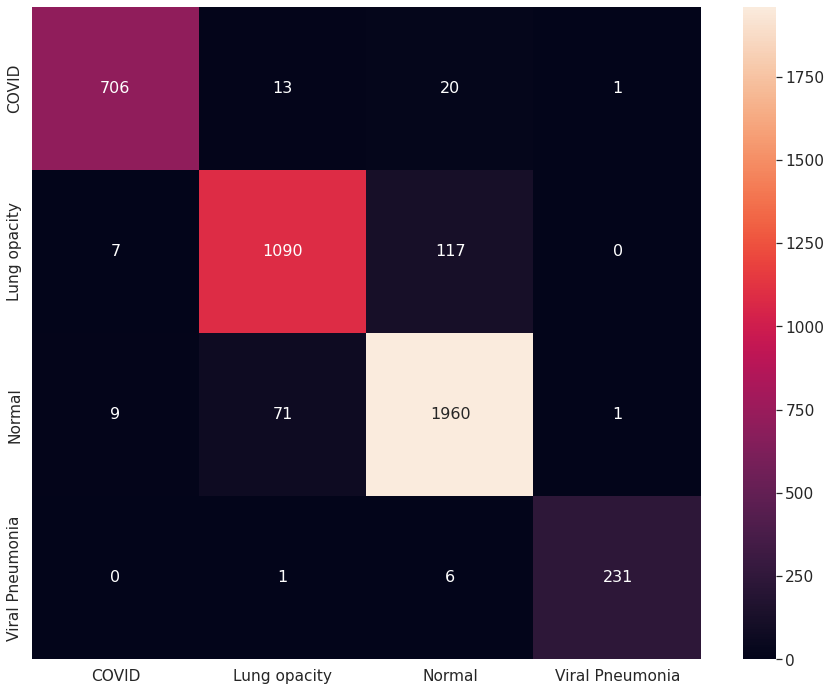

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, test_labels_index)
df_cm = pd.DataFrame(cm, index = [i for i in train_dataset.class_indices],
                  columns = [i for i in train_dataset.class_indices])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()